In [200]:
import numpy as np
from tqdm import tqdm
import datetime 
import zarr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, poisson
from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

def similarity(detectors, signals, phenotype_type='vector'):
    """
    Calculate the similarities between lists of signals and detectors. Signals and detectors can either all be vectors
    or bitstrings.
    """
    match phenotype_type:
        case 'vector':
            return cosine_similarity(detectors, signals)  # Matrix of cosine similarities
        case 'bitstring':
            d = signals.shape[1]
            # Calculate matrix of hamming distances
            detectors_expanded = detectors[:, np.newaxis, :]
            signals_expanded = signals[np.newaxis, :, :]
            hamming_distances = np.sum(detectors_expanded != signals_expanded, axis=2)
            return 1 - hamming_distances/d  # Matrix of fractions of bits that are the same
        case _:
            raise NotImplementedError

# def calculate_predation_matrix(detectors, signals, risk_tols, phenotype_type='vector'):
#     similarity_matrix = similarity(detectors, signals, phenotype_type=phenotype_type)
#     predation_matrix = softmax(similarity_matrix / risk_tols[:, np.newaxis], axis=1)
#     return predation_matrix

def calculate_detection_matrix(detectors, signals, risk_tols, phenotype_type='vector'):
    similarity_matrix = similarity(detectors, signals, phenotype_type=phenotype_type)    

    # map to [0, 1]
    detection_matrix = (similarity_matrix + 1) / 2
    return detection_matrix

def calculate_predation_matrix(detectors, signals, risk_tols, handling_time, phenotype_type='vector'):
    detection_matrix = calculate_detection_matrix(detectors, signals, risk_tols, phenotype_type)
    n_prey = len(signals)
    interaction_prob = 1 / (1 + handling_time * n_prey)
    return interaction_prob * detection_matrix

def sample_predators(predation_matrix, venom_levels, pred_conversion_ratio):
    """
    Sample the predator population based on the predation matrix and venom levels.
    """
    num_predators, num_prey = predation_matrix.shape
    e = predation_matrix.sum(1) * (1 - venom_levels * predation_matrix).prod(1)
    c = []
    for i in range(num_predators):
        mean = pred_conversion_ratio * e[i] / num_predators
        n_i = int(poisson.rvs(mean, size=1)[0])
        c.extend([i for _ in range(n_i)])
    return np.array(c, dtype=np.int64)


def sample_prey(predation_matrix, prey_conversion_ratio):
    """
    Sample the prey population based on the predation matrix.
    """
    num_predators, num_prey = predation_matrix.shape
    fitnesses = np.prod(1 - predation_matrix, axis=0)
    c = []
    for i in range(num_prey):
        mean = prey_conversion_ratio * fitnesses[i] / num_prey
        n_i = int(poisson.rvs(mean, size=1)[0])
        c.extend([i for _ in range(n_i)])
    return np.array(c, dtype=np.int64) # a list of indices of prey


def phenotype_crossover(phenotypes, parents, phenotype_type='vector'):

    # phenotypes can be signals or detectors
    assert len(parents) % 2 == 0, 'Crossover not implemented yet for odd numbers of parents'
    parent_phenotypes = phenotypes[parents]
    child_phenotypes = np.zeros_like(parent_phenotypes)
    match phenotype_type:
        case 'vector':
            interpolation_values = np.random.rand(parent_phenotypes.shape[0] // 2)[:, np.newaxis]
            child_phenotypes[::2]  = interpolation_values * parent_phenotypes[::2] \
                                    + (1 - interpolation_values) * parent_phenotypes[1::2]
            child_phenotypes[1::2] = (1 - interpolation_values) * parent_phenotypes[::2] \
                                    + interpolation_values * parent_phenotypes[1::2]
            return child_phenotypes
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError
        

def phenotype_mutate(phenotypes, mutation_rate=0.01, phenotype_type='vector'):
    """
    Apply random mutations to the bit strings or numerical values.
    """
    num_individuals, d = phenotypes.shape

    match phenotype_type:
        case 'vector':
            # noise = np.random.normal(scale=mutation_rate, size=(num_individuals, d))  # scale mutation rate with d?
            noise = np.random.multivariate_normal(mean=np.zeros(d), cov=mutation_rate*np.eye(d), size=num_individuals)
            return phenotypes + noise
        case 'bitstring':
            # For bit strings, flip bits with some probability
            raise NotImplementedError
        case _:
            raise NotImplementedError


def update(detectors, signals, risk_tols, venom_levels, num_venomous, 
           handling_time=0.8, predator_conversion_ratio=100, prey_conversion_ratio=100,
           mutation_rate=0.01, phenotype_type='vector'):

    assert np.all(venom_levels[num_venomous:] == 0), 'A mimic has a non-zero venom level'

    # venomous_signals, mimic_signals = np.split(signals, [num_venomous])

    predation_matrix = calculate_predation_matrix(detectors, signals, risk_tols, handling_time, phenotype_type=phenotype_type)

    predator_children = sample_predators(predation_matrix, venom_levels, predator_conversion_ratio)
    prey_children = sample_prey(predation_matrix, prey_conversion_ratio)
    # venomous_prey_children = [i for i in prey_children if i < num_venomous]
    # mimic_prey_children    = [i for i in prey_children if i >= num_venomous]
    
    predator_children_detectors = detectors[predator_children]
    prey_children_signals = signals[prey_children]
    
    # predator_childrens_detectors = phenotype_crossover(detectors, predator_parents, phenotype_type=phenotype_type)
    # venomous_childrens_signals = phenotype_crossover(venomous_signals, venomous_parents, phenotype_type=phenotype_type)
    # mimic_childrens_signals    = phenotype_crossover(mimic_signals, mimic_parents, phenotype_type=phenotype_type)

    predator_childrens_detectors = phenotype_mutate(predator_children_detectors, mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    prey_childrens_signals = phenotype_mutate(prey_children_signals, mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    # mimic_childrens_signals = phenotype_mutate(mimic_parents_signals, mutation_rate=mutation_rate, phenotype_type=phenotype_type)

    # prey_childrens_signals = np.vstack((venomous_childrens_signals, mimic_childrens_signals))

    # TODO: make risk tolerances update via crossover and mutation
    predator_childrens_risk_tols = risk_tols[predator_children]
    # TODO: make venom levels update via crossover and mutation
    prey_childrens_venoms = venom_levels[prey_children]

    new_num_venomous = (prey_childrens_venoms > 0).sum()

    print(f"Predators left: {len(predator_children)}")
    print(f"Venomous Prey left: {new_num_venomous}")
    print(f"Mimic Prey left: {(prey_childrens_venoms == 0).sum()}")

    return predator_childrens_detectors, prey_childrens_signals, predator_childrens_risk_tols, prey_childrens_venoms, new_num_venomous

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm
from IPython.display import HTML

Text(0.5, 1.0, 'Initial distributions ($d=2$)')

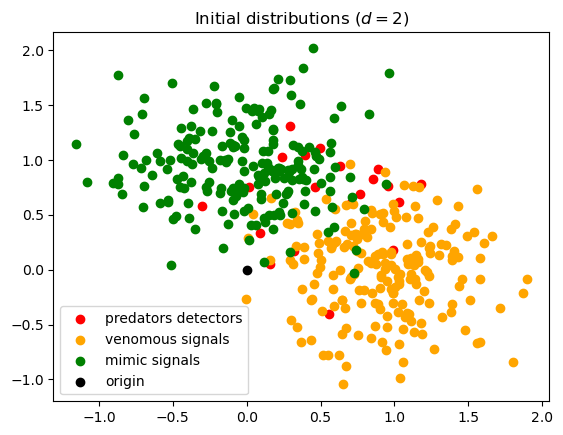

In [211]:
# Initialize population parameters
num_predators = 20
num_venomous_prey = 200
num_mimics = 200
d = 2

mutation_rate = 0.01

predators_detectors_initial_mean = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
predators_detectors_initial_cov = 0.4**2 * np.eye(d)

venomous_signals_initial_mean = np.array([1, 0])
venomous_signals_initial_cov = 0.4**2 * np.eye(d)

mimic_signals_initial_mean = np.array([0, 1])
mimic_signals_initial_cov = 0.4**2 * np.eye(d)

detectors =         np.random.multivariate_normal(mean=predators_detectors_initial_mean,
                                                  cov=predators_detectors_initial_cov,
                                                  size=num_predators)
venomous_signals =  np.random.multivariate_normal(mean=venomous_signals_initial_mean,
                                                  cov=venomous_signals_initial_cov,
                                                  size=num_venomous_prey)
mimic_signals =     np.random.multivariate_normal(mean=mimic_signals_initial_mean,
                                                  cov=mimic_signals_initial_cov,
                                                  size=num_mimics)
signals = np.vstack((venomous_signals, mimic_signals))

risk_tols = np.random.exponential(scale=1., size=num_predators)
venom_levels = np.concatenate((np.random.uniform(0., 1., size=num_venomous_prey), np.zeros(num_mimics)))

plt.scatter(detectors[:, 0], detectors[:, 1], color='red', label='predators detectors')
plt.scatter(signals[:num_venomous_prey, 0], signals[:num_venomous_prey, 1], color='orange', label='venomous signals')
plt.scatter(signals[num_venomous_prey:, 0], signals[num_venomous_prey:, 1], color='green', label='mimic signals')
plt.scatter(0, 0, color='k', label='origin')
plt.legend()
plt.title('Initial distributions ($d=2$)')

In [212]:
num_generations = 20
detectors_history    = []
signals_history      = []
risk_tols_history    = []
venom_levels_history = []
nv_history = []

detectors_history.append(detectors)
signals_history.append(signals)
risk_tols_history.append(risk_tols)
venom_levels_history.append(venom_levels)
nv_history.append(num_venomous_prey)

for t in range(num_generations-1):
    print(f"\n Gen {t}")
    d, s, r, v, nv = update(detectors_history[t], signals_history[t], risk_tols_history[t], venom_levels_history[t], nv_history[t], mutation_rate=mutation_rate, phenotype_type='vector')
    detectors_history.append(d)
    signals_history.append(s)
    risk_tols_history.append(r)
    venom_levels_history.append(v)
    nv_history.append(nv)


 Gen 0
Predators left: 75
Venomous Prey left: 46
Mimic Prey left: 54

 Gen 1
Predators left: 90
Venomous Prey left: 22
Mimic Prey left: 35

 Gen 2
Predators left: 82
Venomous Prey left: 10
Mimic Prey left: 17

 Gen 3
Predators left: 77
Venomous Prey left: 12
Mimic Prey left: 3

 Gen 4
Predators left: 48
Venomous Prey left: 9
Mimic Prey left: 1

 Gen 5
Predators left: 30
Venomous Prey left: 35
Mimic Prey left: 0

 Gen 6
Predators left: 24
Venomous Prey left: 70
Mimic Prey left: 0

 Gen 7
Predators left: 22
Venomous Prey left: 80
Mimic Prey left: 0

 Gen 8
Predators left: 34
Venomous Prey left: 112
Mimic Prey left: 0

 Gen 9
Predators left: 34
Venomous Prey left: 87
Mimic Prey left: 0

 Gen 10
Predators left: 32
Venomous Prey left: 87
Mimic Prey left: 0

 Gen 11
Predators left: 21
Venomous Prey left: 77
Mimic Prey left: 0

 Gen 12
Predators left: 26
Venomous Prey left: 98
Mimic Prey left: 0

 Gen 13
Predators left: 30
Venomous Prey left: 93
Mimic Prey left: 0

 Gen 14
Predators left: 28

In [213]:
steps_per_frame = 1
fig = plt.figure(figsize=(4,4))
ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))
def animate(i):
    # Remove old points
    for artist in ax.get_lines()+ax.collections:  
        artist.remove()

    t = i * steps_per_frame
    num_venomous_prey = nv_history[t]
    pts = []
    ax.scatter(detectors_history[t][ :, 0], detectors_history[t][ :, 1], color='red', label='predators detectors', s=0.2)
    ax.scatter(signals_history[t][ :num_venomous_prey, 0], signals_history[t][ :num_venomous_prey, 1], color='orange', label='venomous signals', s=0.2)
    ax.scatter(signals_history[t][ num_venomous_prey:, 0], signals_history[t][ num_venomous_prey:, 1], color='green', label='mimic signals', s=0.2)
    ax.scatter(0, 0, color='k', label='origin')

    # pts.append(pt1, pt2, pt3, pt4)

    return ax.collections

anim = animation.FuncAnimation(fig, animate, frames=len(detectors_history)//steps_per_frame, interval=50, blit=True)
plt.close()
anim.save('test.gif')
HTML(anim.to_jshtml())